In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-image/test/test/benign/nonca_test_409.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_129.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_1558.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_1447.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_289.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_1204.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_920.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_782.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_642.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_796.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_777.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_355.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_1128.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_1421.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_1057.jpg
/kaggle/input/new-image/test/test/benign/nonca_test_466.jpg
/kaggle/input/new-image/test/test/

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [3]:
os.mkdir("newtrain")
train = os.path.join("newtrain", "train")
valid = os.path.join("newtrain", "valid")
os.mkdir(train)
os.mkdir(valid)
train_benign = os.path.join("newtrain/train", "benign")
train_malignant = os.path.join("newtrain/train", "malignant")
valid_benign = os.path.join("newtrain/valid", "benign")
valid_malignant = os.path.join("newtrain/valid", "malignant")
os.mkdir(train_benign)
os.mkdir(train_malignant)
os.mkdir(valid_benign)
os.mkdir(valid_malignant)

In [4]:
name_ca = list(os.listdir('/kaggle/input/new-image/train/train/malignant'))
len(name_ca)

5040

In [5]:
valid_size = 0.1 
valid_number = int(len(name_ca) * valid_size)
random.shuffle(name_ca)
valid_set_ca = name_ca[:valid_number]
train_set_ca = name_ca[valid_number:]
name_nonca = list(os.listdir('/kaggle/input/new-image/train/train/benign'))
random.shuffle(name_nonca)
valid_set_nonca = name_nonca[:valid_number]
train_set_nonca = name_nonca[valid_number:5040]

In [6]:
print(f"valid for ca = {len(valid_set_ca)}")
print(f"valid for nonca = {len(valid_set_nonca)} ")
print(f"train for ca = {len(train_set_ca)}")
print(f"train for nonca = {len(train_set_nonca)} ")

valid for ca = 504
valid for nonca = 504 
train for ca = 4536
train for nonca = 4536 


In [7]:
import shutil
for ca in valid_set_ca:
    path = '/kaggle/input/new-image/train/train/malignant/'
    shutil.copy(path+ca, '/kaggle/working/newtrain/valid/malignant')
for ca in train_set_ca:
    path = '/kaggle/input/new-image/train/train/malignant/'
    shutil.copy(path+ca, '/kaggle/working/newtrain/train/malignant')
for nonca in valid_set_nonca:
    path = '/kaggle/input/new-image/train/train/benign/'
    shutil.copy(path+nonca, '/kaggle/working/newtrain/valid/benign')
for nonca in train_set_nonca:
    path = '/kaggle/input/new-image/train/train/benign/'
    shutil.copy(path+nonca, '/kaggle/working/newtrain/train/benign')
    

In [8]:
batch_size = 32
img_height = 256
img_width = 256
CCrop = 250
RESIZE = 256

In [9]:
train_dir = '/kaggle/working/newtrain/train'
valid_dir = '/kaggle/working/newtrain/valid'
test_dir = '/kaggle/input/new-image/test/test/'

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  valid_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9072 files belonging to 2 classes.
Found 1008 files belonging to 2 classes.
Found 1865 files belonging to 2 classes.


In [11]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


In [12]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

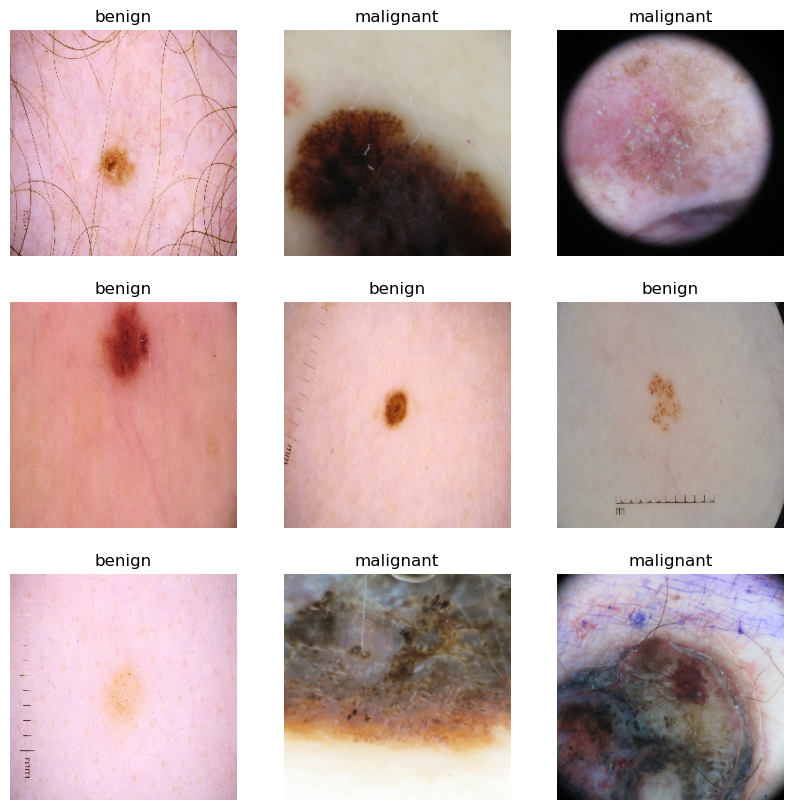

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

In [16]:
import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    
  ]
)

resize_and_rescale = tf.keras.Sequential([
    #layers.CenterCrop(CCrop,CCrop),
    #layers.Resizing(RESIZE, RESIZE),
    layers.Rescaling(1./255.)
])

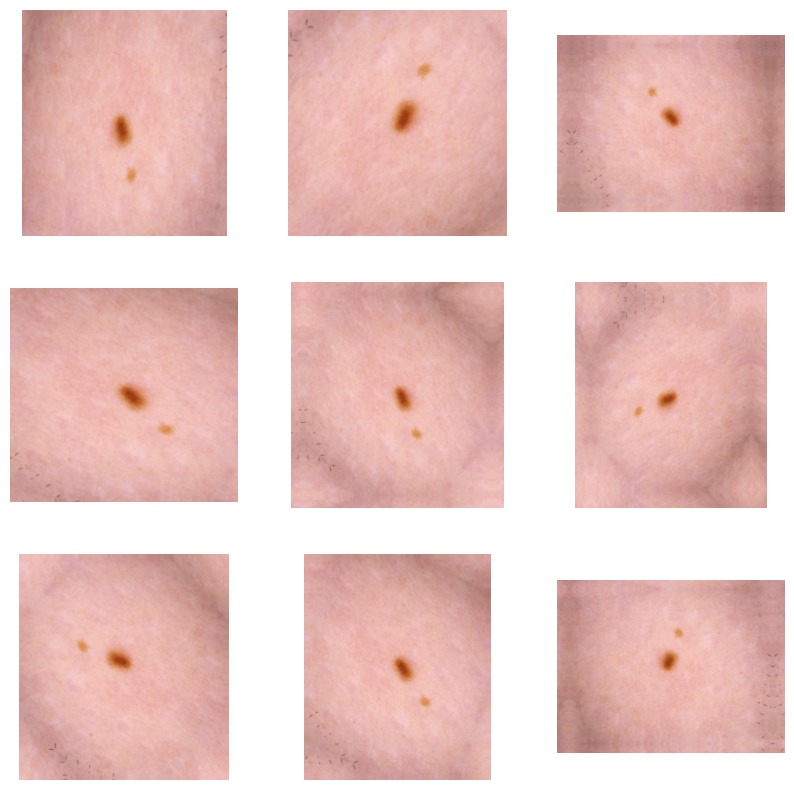

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
train_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y),
  num_parallel_calls=AUTOTUNE)

In [19]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y),
  num_parallel_calls=AUTOTUNE)

In [21]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
vaid = valid_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y),
  num_parallel_calls=AUTOTUNE)

In [24]:
test = test_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y),
  num_parallel_calls=AUTOTUNE)

In [25]:
from tensorflow.keras.applications import ResNet152
pre_trained_model = ResNet152(input_shape = (256,256,3),
                                    include_top = False,
                                    weights = 'imagenet')
    
for layer in pre_trained_model.layers:
  layer.trainable = False

234698864/234698864 [==============================] - 12s 0us/step


In [37]:
my_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=2, min_lr=0.000000001),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_weight.h5',save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    
]

In [39]:
def final_model(pre_trained_model, last_output, lr=0.0001):
    x = layers.Flatten()(last_output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs = pre_trained_model.input,outputs= x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    return model

In [28]:
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# model = tf.keras.Sequential()
# model.add(pre_trained_model)
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer = 'Adam',
#               loss = 'binary_crossentropy',
#               metrics = ['accuracy'])

In [29]:
def output_of_last_layer(pre_trained_model):
  
  last_desired_layer = pre_trained_model.get_layer('top_activation')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  

  return last_output

In [30]:
# pre_trained_model.summary()

In [31]:
last_output = output_of_last_layer(pre_trained_model)

ValueError: No such layer: top_activation. Existing layers are: ['input_1', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_block1_3_bn', 'conv3_block1_add', 'conv3_block1_out', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_2_bn', 'conv3_block2_2_relu', 'conv3_block2_3_conv', 'conv3_block2_3_bn', 'conv3_block2_add', 'conv3_block2_out', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_2_bn', 'conv3_block3_2_relu', 'conv3_block3_3_conv', 'conv3_block3_3_bn', 'conv3_block3_add', 'conv3_block3_out', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_2_bn', 'conv3_block4_2_relu', 'conv3_block4_3_conv', 'conv3_block4_3_bn', 'conv3_block4_add', 'conv3_block4_out', 'conv3_block5_1_conv', 'conv3_block5_1_bn', 'conv3_block5_1_relu', 'conv3_block5_2_conv', 'conv3_block5_2_bn', 'conv3_block5_2_relu', 'conv3_block5_3_conv', 'conv3_block5_3_bn', 'conv3_block5_add', 'conv3_block5_out', 'conv3_block6_1_conv', 'conv3_block6_1_bn', 'conv3_block6_1_relu', 'conv3_block6_2_conv', 'conv3_block6_2_bn', 'conv3_block6_2_relu', 'conv3_block6_3_conv', 'conv3_block6_3_bn', 'conv3_block6_add', 'conv3_block6_out', 'conv3_block7_1_conv', 'conv3_block7_1_bn', 'conv3_block7_1_relu', 'conv3_block7_2_conv', 'conv3_block7_2_bn', 'conv3_block7_2_relu', 'conv3_block7_3_conv', 'conv3_block7_3_bn', 'conv3_block7_add', 'conv3_block7_out', 'conv3_block8_1_conv', 'conv3_block8_1_bn', 'conv3_block8_1_relu', 'conv3_block8_2_conv', 'conv3_block8_2_bn', 'conv3_block8_2_relu', 'conv3_block8_3_conv', 'conv3_block8_3_bn', 'conv3_block8_add', 'conv3_block8_out', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_2_bn', 'conv4_block1_2_relu', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block1_0_bn', 'conv4_block1_3_bn', 'conv4_block1_add', 'conv4_block1_out', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_2_bn', 'conv4_block2_2_relu', 'conv4_block2_3_conv', 'conv4_block2_3_bn', 'conv4_block2_add', 'conv4_block2_out', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_2_bn', 'conv4_block3_2_relu', 'conv4_block3_3_conv', 'conv4_block3_3_bn', 'conv4_block3_add', 'conv4_block3_out', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_2_bn', 'conv4_block4_2_relu', 'conv4_block4_3_conv', 'conv4_block4_3_bn', 'conv4_block4_add', 'conv4_block4_out', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_2_bn', 'conv4_block5_2_relu', 'conv4_block5_3_conv', 'conv4_block5_3_bn', 'conv4_block5_add', 'conv4_block5_out', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_2_bn', 'conv4_block6_2_relu', 'conv4_block6_3_conv', 'conv4_block6_3_bn', 'conv4_block6_add', 'conv4_block6_out', 'conv4_block7_1_conv', 'conv4_block7_1_bn', 'conv4_block7_1_relu', 'conv4_block7_2_conv', 'conv4_block7_2_bn', 'conv4_block7_2_relu', 'conv4_block7_3_conv', 'conv4_block7_3_bn', 'conv4_block7_add', 'conv4_block7_out', 'conv4_block8_1_conv', 'conv4_block8_1_bn', 'conv4_block8_1_relu', 'conv4_block8_2_conv', 'conv4_block8_2_bn', 'conv4_block8_2_relu', 'conv4_block8_3_conv', 'conv4_block8_3_bn', 'conv4_block8_add', 'conv4_block8_out', 'conv4_block9_1_conv', 'conv4_block9_1_bn', 'conv4_block9_1_relu', 'conv4_block9_2_conv', 'conv4_block9_2_bn', 'conv4_block9_2_relu', 'conv4_block9_3_conv', 'conv4_block9_3_bn', 'conv4_block9_add', 'conv4_block9_out', 'conv4_block10_1_conv', 'conv4_block10_1_bn', 'conv4_block10_1_relu', 'conv4_block10_2_conv', 'conv4_block10_2_bn', 'conv4_block10_2_relu', 'conv4_block10_3_conv', 'conv4_block10_3_bn', 'conv4_block10_add', 'conv4_block10_out', 'conv4_block11_1_conv', 'conv4_block11_1_bn', 'conv4_block11_1_relu', 'conv4_block11_2_conv', 'conv4_block11_2_bn', 'conv4_block11_2_relu', 'conv4_block11_3_conv', 'conv4_block11_3_bn', 'conv4_block11_add', 'conv4_block11_out', 'conv4_block12_1_conv', 'conv4_block12_1_bn', 'conv4_block12_1_relu', 'conv4_block12_2_conv', 'conv4_block12_2_bn', 'conv4_block12_2_relu', 'conv4_block12_3_conv', 'conv4_block12_3_bn', 'conv4_block12_add', 'conv4_block12_out', 'conv4_block13_1_conv', 'conv4_block13_1_bn', 'conv4_block13_1_relu', 'conv4_block13_2_conv', 'conv4_block13_2_bn', 'conv4_block13_2_relu', 'conv4_block13_3_conv', 'conv4_block13_3_bn', 'conv4_block13_add', 'conv4_block13_out', 'conv4_block14_1_conv', 'conv4_block14_1_bn', 'conv4_block14_1_relu', 'conv4_block14_2_conv', 'conv4_block14_2_bn', 'conv4_block14_2_relu', 'conv4_block14_3_conv', 'conv4_block14_3_bn', 'conv4_block14_add', 'conv4_block14_out', 'conv4_block15_1_conv', 'conv4_block15_1_bn', 'conv4_block15_1_relu', 'conv4_block15_2_conv', 'conv4_block15_2_bn', 'conv4_block15_2_relu', 'conv4_block15_3_conv', 'conv4_block15_3_bn', 'conv4_block15_add', 'conv4_block15_out', 'conv4_block16_1_conv', 'conv4_block16_1_bn', 'conv4_block16_1_relu', 'conv4_block16_2_conv', 'conv4_block16_2_bn', 'conv4_block16_2_relu', 'conv4_block16_3_conv', 'conv4_block16_3_bn', 'conv4_block16_add', 'conv4_block16_out', 'conv4_block17_1_conv', 'conv4_block17_1_bn', 'conv4_block17_1_relu', 'conv4_block17_2_conv', 'conv4_block17_2_bn', 'conv4_block17_2_relu', 'conv4_block17_3_conv', 'conv4_block17_3_bn', 'conv4_block17_add', 'conv4_block17_out', 'conv4_block18_1_conv', 'conv4_block18_1_bn', 'conv4_block18_1_relu', 'conv4_block18_2_conv', 'conv4_block18_2_bn', 'conv4_block18_2_relu', 'conv4_block18_3_conv', 'conv4_block18_3_bn', 'conv4_block18_add', 'conv4_block18_out', 'conv4_block19_1_conv', 'conv4_block19_1_bn', 'conv4_block19_1_relu', 'conv4_block19_2_conv', 'conv4_block19_2_bn', 'conv4_block19_2_relu', 'conv4_block19_3_conv', 'conv4_block19_3_bn', 'conv4_block19_add', 'conv4_block19_out', 'conv4_block20_1_conv', 'conv4_block20_1_bn', 'conv4_block20_1_relu', 'conv4_block20_2_conv', 'conv4_block20_2_bn', 'conv4_block20_2_relu', 'conv4_block20_3_conv', 'conv4_block20_3_bn', 'conv4_block20_add', 'conv4_block20_out', 'conv4_block21_1_conv', 'conv4_block21_1_bn', 'conv4_block21_1_relu', 'conv4_block21_2_conv', 'conv4_block21_2_bn', 'conv4_block21_2_relu', 'conv4_block21_3_conv', 'conv4_block21_3_bn', 'conv4_block21_add', 'conv4_block21_out', 'conv4_block22_1_conv', 'conv4_block22_1_bn', 'conv4_block22_1_relu', 'conv4_block22_2_conv', 'conv4_block22_2_bn', 'conv4_block22_2_relu', 'conv4_block22_3_conv', 'conv4_block22_3_bn', 'conv4_block22_add', 'conv4_block22_out', 'conv4_block23_1_conv', 'conv4_block23_1_bn', 'conv4_block23_1_relu', 'conv4_block23_2_conv', 'conv4_block23_2_bn', 'conv4_block23_2_relu', 'conv4_block23_3_conv', 'conv4_block23_3_bn', 'conv4_block23_add', 'conv4_block23_out', 'conv4_block24_1_conv', 'conv4_block24_1_bn', 'conv4_block24_1_relu', 'conv4_block24_2_conv', 'conv4_block24_2_bn', 'conv4_block24_2_relu', 'conv4_block24_3_conv', 'conv4_block24_3_bn', 'conv4_block24_add', 'conv4_block24_out', 'conv4_block25_1_conv', 'conv4_block25_1_bn', 'conv4_block25_1_relu', 'conv4_block25_2_conv', 'conv4_block25_2_bn', 'conv4_block25_2_relu', 'conv4_block25_3_conv', 'conv4_block25_3_bn', 'conv4_block25_add', 'conv4_block25_out', 'conv4_block26_1_conv', 'conv4_block26_1_bn', 'conv4_block26_1_relu', 'conv4_block26_2_conv', 'conv4_block26_2_bn', 'conv4_block26_2_relu', 'conv4_block26_3_conv', 'conv4_block26_3_bn', 'conv4_block26_add', 'conv4_block26_out', 'conv4_block27_1_conv', 'conv4_block27_1_bn', 'conv4_block27_1_relu', 'conv4_block27_2_conv', 'conv4_block27_2_bn', 'conv4_block27_2_relu', 'conv4_block27_3_conv', 'conv4_block27_3_bn', 'conv4_block27_add', 'conv4_block27_out', 'conv4_block28_1_conv', 'conv4_block28_1_bn', 'conv4_block28_1_relu', 'conv4_block28_2_conv', 'conv4_block28_2_bn', 'conv4_block28_2_relu', 'conv4_block28_3_conv', 'conv4_block28_3_bn', 'conv4_block28_add', 'conv4_block28_out', 'conv4_block29_1_conv', 'conv4_block29_1_bn', 'conv4_block29_1_relu', 'conv4_block29_2_conv', 'conv4_block29_2_bn', 'conv4_block29_2_relu', 'conv4_block29_3_conv', 'conv4_block29_3_bn', 'conv4_block29_add', 'conv4_block29_out', 'conv4_block30_1_conv', 'conv4_block30_1_bn', 'conv4_block30_1_relu', 'conv4_block30_2_conv', 'conv4_block30_2_bn', 'conv4_block30_2_relu', 'conv4_block30_3_conv', 'conv4_block30_3_bn', 'conv4_block30_add', 'conv4_block30_out', 'conv4_block31_1_conv', 'conv4_block31_1_bn', 'conv4_block31_1_relu', 'conv4_block31_2_conv', 'conv4_block31_2_bn', 'conv4_block31_2_relu', 'conv4_block31_3_conv', 'conv4_block31_3_bn', 'conv4_block31_add', 'conv4_block31_out', 'conv4_block32_1_conv', 'conv4_block32_1_bn', 'conv4_block32_1_relu', 'conv4_block32_2_conv', 'conv4_block32_2_bn', 'conv4_block32_2_relu', 'conv4_block32_3_conv', 'conv4_block32_3_bn', 'conv4_block32_add', 'conv4_block32_out', 'conv4_block33_1_conv', 'conv4_block33_1_bn', 'conv4_block33_1_relu', 'conv4_block33_2_conv', 'conv4_block33_2_bn', 'conv4_block33_2_relu', 'conv4_block33_3_conv', 'conv4_block33_3_bn', 'conv4_block33_add', 'conv4_block33_out', 'conv4_block34_1_conv', 'conv4_block34_1_bn', 'conv4_block34_1_relu', 'conv4_block34_2_conv', 'conv4_block34_2_bn', 'conv4_block34_2_relu', 'conv4_block34_3_conv', 'conv4_block34_3_bn', 'conv4_block34_add', 'conv4_block34_out', 'conv4_block35_1_conv', 'conv4_block35_1_bn', 'conv4_block35_1_relu', 'conv4_block35_2_conv', 'conv4_block35_2_bn', 'conv4_block35_2_relu', 'conv4_block35_3_conv', 'conv4_block35_3_bn', 'conv4_block35_add', 'conv4_block35_out', 'conv4_block36_1_conv', 'conv4_block36_1_bn', 'conv4_block36_1_relu', 'conv4_block36_2_conv', 'conv4_block36_2_bn', 'conv4_block36_2_relu', 'conv4_block36_3_conv', 'conv4_block36_3_bn', 'conv4_block36_add', 'conv4_block36_out', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_0_bn', 'conv5_block1_3_bn', 'conv5_block1_add', 'conv5_block1_out', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_2_relu', 'conv5_block2_3_conv', 'conv5_block2_3_bn', 'conv5_block2_add', 'conv5_block2_out', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out'].

In [40]:
last_output = pre_trained_model.layers[-1].output

In [41]:
model = final_model(pre_trained_model, last_output)

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [42]:
history = model.fit(train_ds,
                    validation_data = vaid,
                    epochs = 25,
                    verbose=1,
                    callbacks=my_callbacks)

Epoch 1/25
284/284 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.5741
Epoch 1: val_loss did not improve from 0.58175
284/284 [==============================] - 435s 1s/step - loss: 0.7576 - accuracy: 0.5741 - val_loss: 0.6226 - val_accuracy: 0.7560 - lr: 1.0000e-04
Epoch 2/25
284/284 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.6377
Epoch 2: val_loss did not improve from 0.58175
284/284 [==============================] - 387s 1s/step - loss: 0.6238 - accuracy: 0.6377 - val_loss: 0.6138 - val_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 3/25
284/284 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.6812
Epoch 3: val_loss improved from 0.58175 to 0.55625, saving model to model_weight.h5
284/284 [==============================] - 393s 1s/step - loss: 0.5839 - accuracy: 0.6812 - val_loss: 0.5562 - val_accuracy: 0.7649 - lr: 1.0000e-04
Epoch 4/25
284/284 [==============================] - ETA: 0s - loss: 0.5576 - accuracy

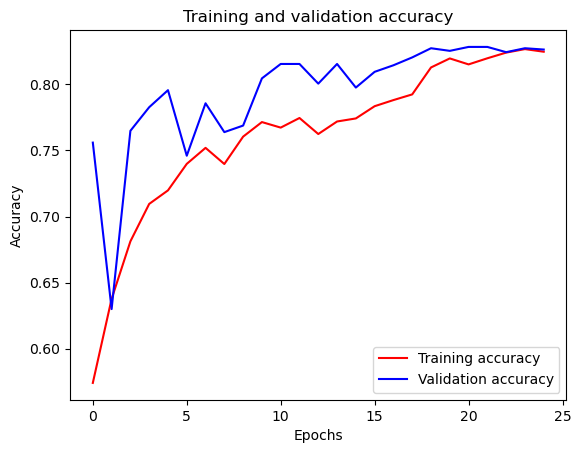

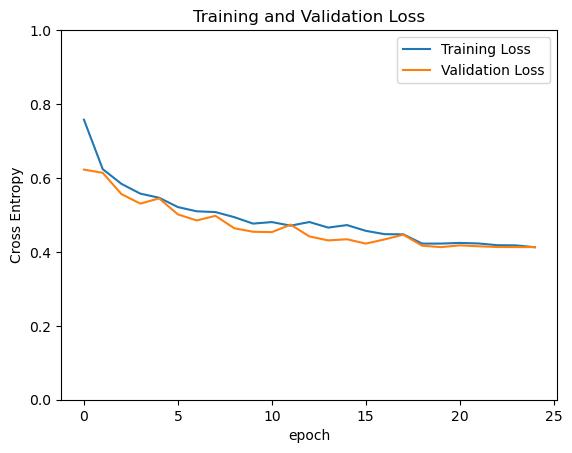

In [50]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



plt.show()

In [57]:
model.evaluate(test)

59/59 [==============================] - 107s 2s/step - loss: 0.4163 - accuracy: 0.8542


[0.41631022095680237, 0.8541554808616638]

In [58]:

probabilities = model.predict(test)

59/59 [==============================] - 105s 2s/step


In [59]:
probabilities

array([[0.23727341],
       [0.34513992],
       [0.21813476],
       ...,
       [0.17446694],
       [0.2110789 ],
       [1.        ]], dtype=float32)

In [105]:
predict = [0 if i < 0.3 else 1 for i in probabilities]

In [48]:
model.save("resnet152.h5")

In [106]:
test_gen = ImageDataGenerator(rescale=1./255)
test_ds = test_gen.flow_from_directory(
          test_dir,
          target_size=(img_height, img_width),
          class_mode=None,
          batch_size=batch_size,
          shuffle=False)

Found 1865 images belonging to 2 classes.


In [77]:
predict_test = model.predict(test_ds)

59/59 [==============================] - 304s 5s/step


In [107]:
labels = test_ds.classes

In [108]:
test_ds.class_indices

{'benign': 0, 'malignant': 1}

In [109]:
labels_test = (test_ds.class_indices)
labels_test = dict((v,k) for k,v in labels_test.items())
predictions_test = [labels_test[k] for k in predict]

In [110]:
predictions_test 

['benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 '

In [111]:
filenames=test_ds.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions_test})

In [112]:
results

Filename Predictions
0        benign/nonca_test_0.jpg      benign
1        benign/nonca_test_1.jpg   malignant
2       benign/nonca_test_10.jpg      benign
3      benign/nonca_test_100.jpg      benign
4     benign/nonca_test_1000.jpg   malignant
...                          ...         ...
1860    malignant/ca_test_95.jpg      benign
1861    malignant/ca_test_96.jpg      benign
1862    malignant/ca_test_97.jpg      benign
1863    malignant/ca_test_98.jpg      benign
1864    malignant/ca_test_99.jpg   malignant

[1865 rows x 2 columns]

In [97]:
results[results['Predictions']=='malignant']

Empty DataFrame
Columns: [Filename, Predictions]
Index: []

In [76]:
test_ds.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

              precision    recall  f1-score   support

           0       0.86      0.60      0.70      1600
           1       0.14      0.41      0.21       265

    accuracy                           0.57      1865
   macro avg       0.50      0.50      0.46      1865
weighted avg       0.76      0.57      0.63      1865



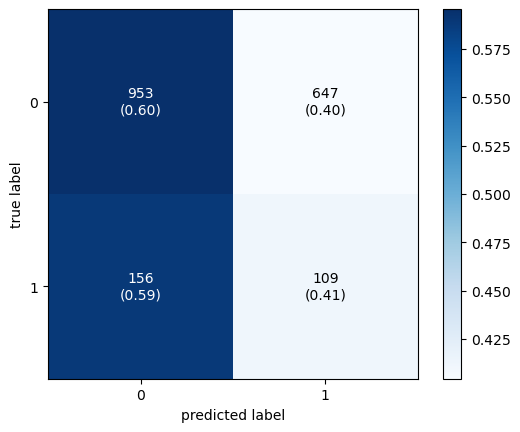

In [113]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(labels, predict))
cm1 = confusion_matrix(labels, predict)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

In [114]:
from sklearn.metrics import recall_score
recall_score(labels, predict)

0.41132075471698115

In [104]:
test_dir

'/kaggle/input/new-image/test/test/'

In [128]:
malignant = test_dir+'malignant/'
benign = test_dir+'benign/'

In [129]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as pl

In [130]:
print(malignant)
print(benign)

/kaggle/input/new-image/test/test/malignant/
/kaggle/input/new-image/test/test/benign/


In [131]:
namec = list(os.listdir(malignant))
namena = list(os.listdir(benign))

In [144]:
len(namec)

265

In [145]:
len(namena)

1600

In [147]:
predict_new = []
label_new = []

In [148]:
for name in namec:
    img_path = malignant + name
    img = load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = img_array/255.
    img_batch = np.expand_dims(img_array, axis=0)   
    pred = model.predict(img_batch)
    if pred < 0.5 :
        predict_new.append(0)
        label_new.append(1)
    else :
        predict_new.append(1)
        label_new.append(1)
        


1/1 [==============================] - 0s 41ms/step


In [153]:
for name in namena:
    img_path = benign + name
    img = load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = img_array/255.
    img_batch = np.expand_dims(img_array, axis=0)   
    pred = model.predict(img_batch)
    if pred < 0.5 :
        predict_new.append(0)
        label_new.append(0)
    else:
        predict_new.append(1)
        label_new.append(0)

1/1 [==============================] - 0s 42ms/step


In [154]:
len(label_new)

1865

In [155]:
len(predict_new)

1865

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1600
           1       0.51      0.77      0.61       265

    accuracy                           0.86      1865
   macro avg       0.73      0.82      0.76      1865
weighted avg       0.89      0.86      0.87      1865



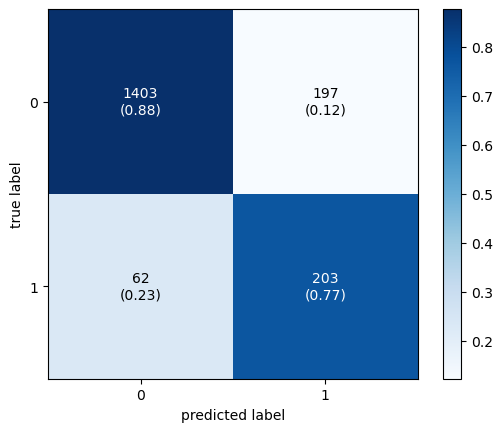

In [156]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
print(classification_report(label_new, predict_new))
cm1 = confusion_matrix(label_new, predict_new)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.show()

In [158]:
total_name = namec + namena

In [164]:
result = pd.DataFrame({"name":total_name,
                      "label":label_new,
                      "Prediction":predict_new})

In [165]:
result

name  label  Prediction
0         ca_test_119.jpg      1           1
1         ca_test_233.jpg      1           1
2          ca_test_60.jpg      1           1
3          ca_test_16.jpg      1           0
4          ca_test_22.jpg      1           1
...                   ...    ...         ...
1860  nonca_test_1409.jpg      0           0
1861  nonca_test_1505.jpg      0           0
1862  nonca_test_1314.jpg      0           0
1863   nonca_test_654.jpg      0           0
1864  nonca_test_1521.jpg      0           0

[1865 rows x 3 columns]

In [169]:
ca = result['label']==1
predict = result['Prediction']==0
final = result[ca & predict]

In [170]:
final

name  label  Prediction
3     ca_test_16.jpg      1           0
7      ca_test_9.jpg      1           0
10   ca_test_261.jpg      1           0
12   ca_test_234.jpg      1           0
16   ca_test_176.jpg      1           0
..               ...    ...         ...
243  ca_test_131.jpg      1           0
248   ca_test_43.jpg      1           0
254  ca_test_262.jpg      1           0
258   ca_test_98.jpg      1           0
264  ca_test_263.jpg      1           0

[62 rows x 3 columns]

In [173]:
miss_ca = list(final['name'])
miss_ca

['ca_test_16.jpg',
 'ca_test_9.jpg',
 'ca_test_261.jpg',
 'ca_test_234.jpg',
 'ca_test_176.jpg',
 'ca_test_7.jpg',
 'ca_test_77.jpg',
 'ca_test_137.jpg',
 'ca_test_34.jpg',
 'ca_test_136.jpg',
 'ca_test_45.jpg',
 'ca_test_56.jpg',
 'ca_test_87.jpg',
 'ca_test_2.jpg',
 'ca_test_86.jpg',
 'ca_test_228.jpg',
 'ca_test_224.jpg',
 'ca_test_247.jpg',
 'ca_test_35.jpg',
 'ca_test_166.jpg',
 'ca_test_118.jpg',
 'ca_test_101.jpg',
 'ca_test_258.jpg',
 'ca_test_105.jpg',
 'ca_test_40.jpg',
 'ca_test_245.jpg',
 'ca_test_159.jpg',
 'ca_test_239.jpg',
 'ca_test_259.jpg',
 'ca_test_14.jpg',
 'ca_test_232.jpg',
 'ca_test_242.jpg',
 'ca_test_74.jpg',
 'ca_test_39.jpg',
 'ca_test_244.jpg',
 'ca_test_250.jpg',
 'ca_test_10.jpg',
 'ca_test_133.jpg',
 'ca_test_24.jpg',
 'ca_test_255.jpg',
 'ca_test_243.jpg',
 'ca_test_181.jpg',
 'ca_test_5.jpg',
 'ca_test_125.jpg',
 'ca_test_17.jpg',
 'ca_test_241.jpg',
 'ca_test_46.jpg',
 'ca_test_90.jpg',
 'ca_test_227.jpg',
 'ca_test_235.jpg',
 'ca_test_44.jpg',
 'ca_t

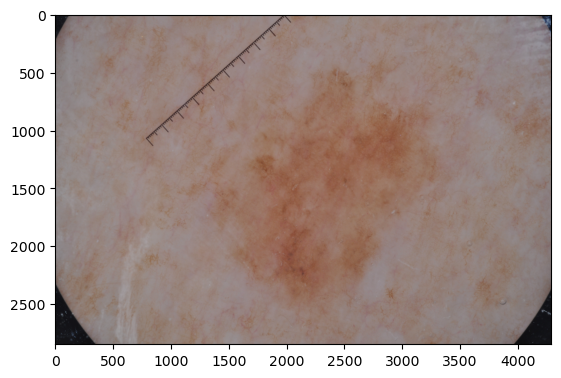

In [187]:
import random
n = random.randint(0, len(miss_ca))
img_miss = plt.imread(malignant+miss_ca[n])
plt.imshow(img_miss)

In [ ]:
img_height_600 = 512
img_width_600 = 512
batch_size_16 = 16
train_ds_600 = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height_600, img_width_600),
  batch_size=batch_size_16)

valid_ds_600 = tf.keras.utils.image_dataset_from_directory(
  valid_dir,
  image_size=(img_height_600, img_width_600),
  batch_size=batch_size_16)